<a href="https://www.kaggle.com/code/zwelimashego/marketing-insights-for-ecommerce?scriptVersionId=189190968" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 8.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.8 MB/s eta 0:00:00


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_calibration_purchases_vs_holdout_purchases,plot_period_transactions,plot_history_alive
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/marketing-insights-for-e-commerce-company/Online_Sales.csv
/kaggle/input/marketing-insights-for-e-commerce-company/CustomersData.xlsx
/kaggle/input/marketing-insights-for-e-commerce-company/Marketing_Spend.csv
/kaggle/input/marketing-insights-for-e-commerce-company/Discount_Coupon.csv
/kaggle/input/marketing-insights-for-e-commerce-company/Tax_amount.xlsx


# intro

<b>Let us look into one of the most important aspects that aids in strategic marketing, Customer lifetime value and churn rate. we are going to use BG/NBD and GammaGamma models to predict the CLV and future transactions of the customer in given times. Thus, we are going to pull Online_Sales.csv.

In a nutshell the following will be the outcomes:
* Predicting how often a visitor will return to the website
* Predicting individuals who have churned from the web
* Predicting repeat purchases from a customer in different periods
* Predicting the lifetime value of your customers
* Customer segmentation
</b>

In [3]:
#reading the dataset
df = pd.read_csv('/kaggle/input/marketing-insights-for-e-commerce-company/Online_Sales.csv')

In [4]:
df.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used


# Data wrangling and understanding

In [5]:
df

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used
...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,12/31/2019,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked
52920,14410,48494,12/31/2019,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used
52921,14410,48495,12/31/2019,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used
52922,14600,48496,12/31/2019,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked


In [6]:
df.isnull().sum()

CustomerID             0
Transaction_ID         0
Transaction_Date       0
Product_SKU            0
Product_Description    0
Product_Category       0
Quantity               0
Avg_Price              0
Delivery_Charges       0
Coupon_Status          0
dtype: int64

In [7]:
df.dtypes

CustomerID               int64
Transaction_ID           int64
Transaction_Date        object
Product_SKU             object
Product_Description     object
Product_Category        object
Quantity                 int64
Avg_Price              float64
Delivery_Charges       float64
Coupon_Status           object
dtype: object

**Converting variables into proper format e.g date variable to datetime**

In [8]:
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])
df.dtypes

CustomerID                      int64
Transaction_ID                  int64
Transaction_Date       datetime64[ns]
Product_SKU                    object
Product_Description            object
Product_Category               object
Quantity                        int64
Avg_Price                     float64
Delivery_Charges              float64
Coupon_Status                  object
dtype: object

**Let's see what the outliers look like**

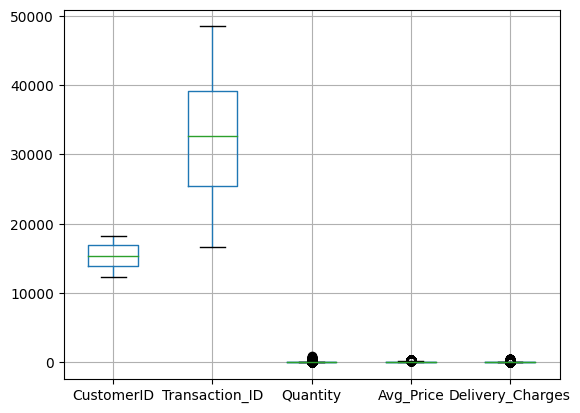

In [9]:
df.boxplot()
plt.show()

**Removing outliers**

In [10]:
def outlier_thresholds(df,feature,q1=0.05, q3=0.95):
    Q1 = df[feature].quantile(q1)
    Q3 = df[feature].quantile(q3)
    IQR = Q3 - Q1
    lower_bound = int(round(Q1 - 1.5 * IQR))
    upper_bound = int(round(Q3 + 1.5 * IQR))
    return lower_bound, upper_bound
def repace_with_thresholds(df,feature):
    lower_bound,upper_bound = outlier_thresholds(df,feature)
    df.loc[(df[feature]<lower_bound), feature] = lower_bound
    df.loc[(df[feature]>upper_bound), feature] = upper_bound

In [11]:
repace_with_thresholds(df,'Quantity')
repace_with_thresholds(df,'Avg_Price')

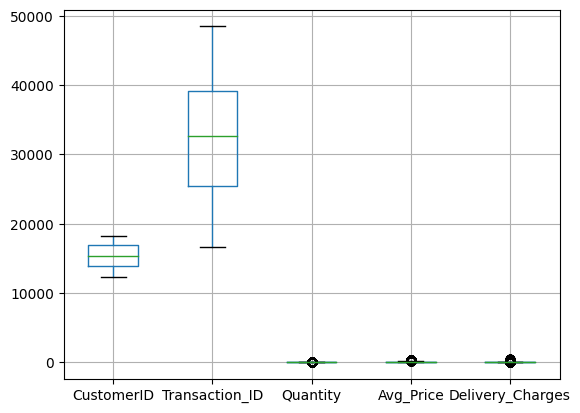

In [12]:
df.boxplot()
plt.show()

# Descriptive Analysis

In [13]:
df

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used
...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,2019-12-31,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked
52920,14410,48494,2019-12-31,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used
52921,14410,48495,2019-12-31,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used
52922,14600,48496,2019-12-31,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked


In [14]:
df.describe()

,CustomerID,Transaction_ID,Transaction_Date,Quantity,Avg_Price,Delivery_Charges
count,52924.00000,52924.000000,52924,52924.000000,52924.000000,52924.000000
mean,15346.70981,32409.825675,2019-07-05 19:16:09.450532864,3.322047,52.237646,10.517630
min,12346.00000,16679.000000,2019-01-01 00:00:00,1.000000,0.390000,0.000000
25%,13869.00000,25384.000000,2019-04-12 00:00:00,1.000000,5.700000,6.000000
50%,15311.00000,32625.500000,2019-07-13 00:00:00,1.000000,16.990000,6.000000
75%,16996.25000,39126.250000,2019-09-27 00:00:00,2.000000,102.130000,6.500000
max,18283.00000,48497.000000,2019-12-31 00:00:00,38.000000,355.740000,521.360000
std,1766.55602,8648.668977,NaN,6.715816,64.006882,19.475613


**We need to make use of Rececny Frequency Model, and in order to do that we need to have avg_monetary and total spent per customer**

In [15]:
total_spent = df.groupby('CustomerID')['Avg_Price'].sum().reset_index()
total_spent = total_spent.rename(columns={'Avg_Price': 'total_spent'})
df = df.merge(total_spent, on='CustomerID', how='left')
df.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,total_spent
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,20483.98
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,20483.98
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,20483.98
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,20483.98
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,20483.98


In [16]:
df['Transaction_Date'].max()

Timestamp('2019-12-31 00:00:00')

# Transforming the transaction data into summary data(frequency, recency, and age dataset)
**we need our data in the above format in order to use our predictive models**

In [17]:
transaction_summary = summary_data_from_transaction_data(df,'CustomerID','Transaction_Date',observation_period_end ='2019-12-31')
transaction_summary.head()

,frequency,recency,T
CustomerID,,,
12346,0.0,0.0,107.0
12347,2.0,223.0,282.0
12348,1.0,119.0,192.0
12350,0.0,0.0,17.0
12356,0.0,0.0,107.0


In [18]:
transaction_summary['Customer_ID'] = transaction_summary.index.tolist()
transaction_summary = transaction_summary.rename_axis('index')
# Let's move Customer ID to the first position
column_to_move = 'Customer_ID'
# Removing the column and insert it at the first position
col = transaction_summary.pop(column_to_move)
transaction_summary.insert(0, column_to_move, col)
transaction_summary.head()
transaction_summary['monetary_avg'] = df['total_spent']/df['Quantity']
transaction_summary.head()

,Customer_ID,frequency,recency,T,monetary_avg
index,,,,,
12346,12346,0.0,0.0,107.0,451.103333
12347,12347,2.0,223.0,282.0,1353.310000
12348,12348,1.0,119.0,192.0,1353.310000
12350,12350,0.0,0.0,17.0,1353.310000
12356,12356,0.0,0.0,107.0,6266.620000


# Establishing our predictive models BG/NBD and Gamma-Gamma

<h2>BG/NBD Model</h2>

In [19]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(transaction_summary['frequency'],transaction_summary['recency'],transaction_summary['T'])


<lifetimes.BetaGeoFitter: fitted with 1468 subjects, a: 0.43, alpha: 61.05, b: 1.05, r: 0.54>

# BG/NBD Model Evaluation

In [20]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.540506,0.045016,0.452275,0.628737
alpha,61.048752,7.657748,46.039566,76.057938
a,0.434709,0.091316,0.255729,0.613689
b,1.054471,0.243620,0.576977,1.531966


**The above coefficients shows to be within the lower and upper bounds which confirms a good accuracy of the model and we can rely on the predictions it makes**

**We are about to predict the transactions per different periods**

Before we do that though, we need to validate our model further by comparison of a data split so we can enhance our confidence

In [21]:
df['Transaction_Date'].min()

Timestamp('2019-01-01 00:00:00')

In [22]:
df['Transaction_Date'].max()

Timestamp('2019-12-31 00:00:00')

In [23]:
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'Transaction_Date',
calibration_period_end='2019-11-30',
observation_period_end='2019-12-31' )

summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,0.0,0.0,76.0,0.0,31.0
12347,2.0,223.0,251.0,0.0,31.0
12348,1.0,119.0,161.0,0.0,31.0
12356,0.0,0.0,76.0,0.0,31.0
12359,0.0,0.0,99.0,0.0,31.0


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

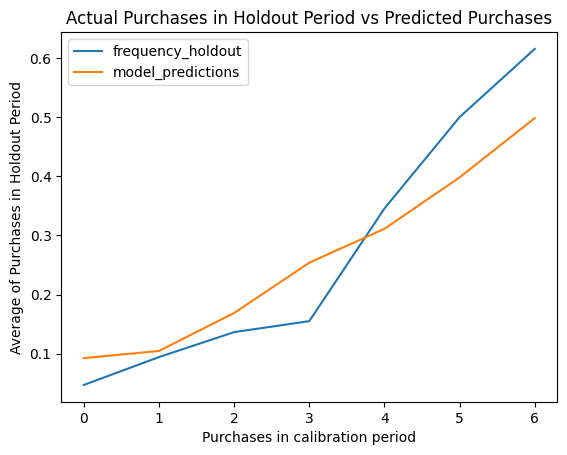

In [24]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

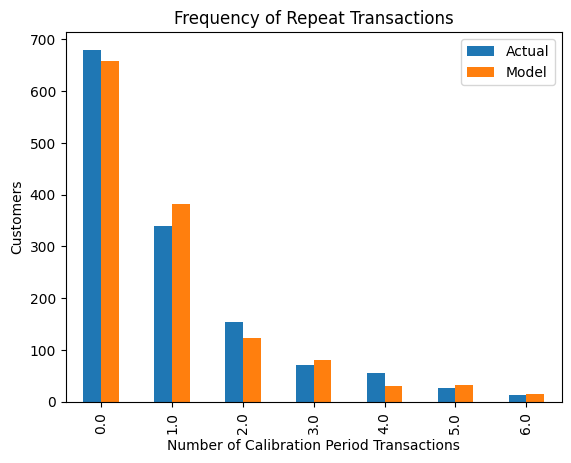

In [25]:
plot_period_transactions(bgf)
plt.show()

**As we can see, the model's prediction seems to be well inline with the real data**

<h3>Predicting how often a visitor will return to a website</h3>

**Visualizing our Frequency/Recency Matrix**

Let us visualize the predicited transaction a customer will make in the next period using their recency(age at last purchase: time of first purchase minus last purchase) and frequency( the number of repeat purchases the customer made minus one).

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

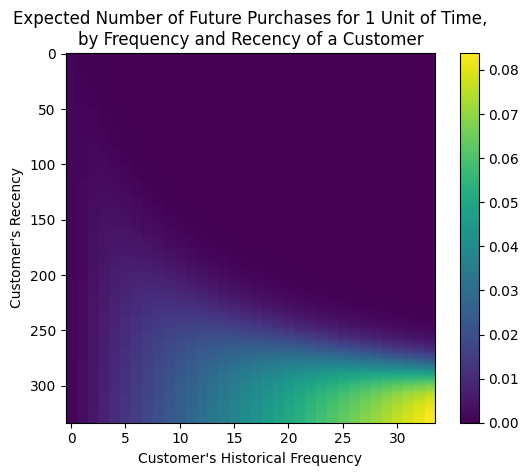

In [26]:
plot_frequency_recency_matrix(bgf)

* **As we can see in the matrix, the customer who bought  30 times and they are 350 weeks old, they are the best customer**
* **The tail furthur to the right represents customers that buys infrequent but we have seen recently, we are not sure if they will come back**
* **On the top right lies the coldest customers, they bought a lot quickly and were never seen in weeks**

**Let's paint a picture of customers who have churned from the website**

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

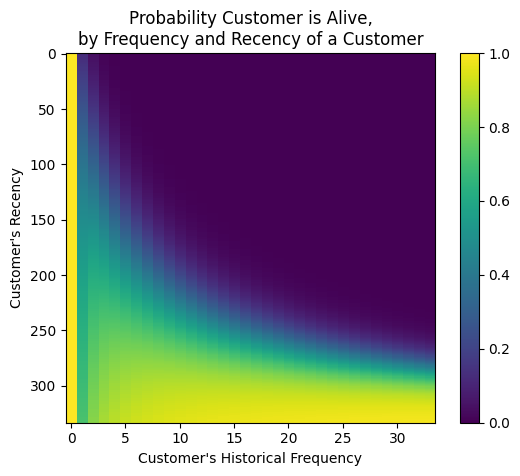

In [27]:
plot_probability_alive_matrix(bgf)

**As we can see, between customers who bought 6 times & are 50 weeks old and those who bought 35 times & are 255 weeks old lies customers who have stopped using the service.**

<h2>Let us look at each customer's future transactions</h2>

<h3>Predicting repeat purchases from a customer in different periods</h3>

**In 3 months**

In [28]:
t = 4*3 #predict purchases in 3 months
customer = transaction_summary
# The below function is an alias to `bgf.conditional_expected_number_of_purchases_up_to_time`
transaction_summary['predict_3_months_trans'] = bgf.predict(t, customer['frequency'], customer['recency'], customer['T'])
transaction_summary

,Customer_ID,frequency,recency,T,monetary_avg,predict_3_months_trans
index,,,,,,
12346,12346,0.0,0.0,107.0,451.103333,0.039194
12347,12347,2.0,223.0,282.0,1353.310000,0.065568
12348,12348,1.0,119.0,192.0,1353.310000,0.043527
12350,12350,0.0,0.0,17.0,1353.310000,0.082778
12356,12356,0.0,0.0,107.0,6266.620000,0.039194
...,...,...,...,...,...,...
18259,18259,0.0,0.0,270.0,52.346000,0.020066
18260,18260,2.0,105.0,192.0,52.346000,0.073144
18269,18269,1.0,76.0,270.0,666.839000,0.021747


**In 6 months**

In [29]:
t = 4*6 #predict purchases in 6 months
customer = transaction_summary
# The below function is an alias to `bgf.conditional_expected_number_of_purchases_up_to_time`
transaction_summary['predict_6_months_trans'] = bgf.predict(t, customer['frequency'], customer['recency'], customer['T'])
transaction_summary

,Customer_ID,frequency,recency,T,monetary_avg,predict_3_months_trans,predict_6_months_trans
index,,,,,,,
12346,12346,0.0,0.0,107.0,451.103333,0.039194,0.077242
12347,12347,2.0,223.0,282.0,1353.310000,0.065568,0.130116
12348,12348,1.0,119.0,192.0,1353.310000,0.043527,0.086161
12350,12350,0.0,0.0,17.0,1353.310000,0.082778,0.160775
12356,12356,0.0,0.0,107.0,6266.620000,0.039194,0.077242
...,...,...,...,...,...,...,...
18259,18259,0.0,0.0,270.0,52.346000,0.020066,0.039823
18260,18260,2.0,105.0,192.0,52.346000,0.073144,0.144769
18269,18269,1.0,76.0,270.0,666.839000,0.021747,0.043149


<h2>Predicting the lifetime value of your customers</h2>

**Now we need to know what the future value of the tranctions are per customer**

We are going to use GammaGamma model to predict the future revenue value of each customer, Gamma Gamma model assumes the following:

* The customer is a returning customer
* The monetary value and frequency of purchases do not correlate

In [30]:
returning_customer = transaction_summary[transaction_summary['frequency']>0]
returning_customer.head()

,Customer_ID,frequency,recency,T,monetary_avg,predict_3_months_trans,predict_6_months_trans
index,,,,,,,
12347,12347,2.0,223.0,282.0,1353.31,0.065568,0.130116
12348,12348,1.0,119.0,192.0,1353.31,0.043527,0.086161
12370,12370,1.0,30.0,219.0,6266.62,0.020080,0.039787
12377,12377,1.0,139.0,179.0,6266.62,0.050283,0.099483
12383,12383,3.0,72.0,171.0,1639.47,0.087323,0.172664


In [31]:
returning_customer[['frequency','monetary_avg']].corr()

,frequency,monetary_avg
frequency,1.000000,0.093156
monetary_avg,0.093156,1.000000


In the cofusion matrix, the frequency and monetary_avg is very close to zero, confirming the independence in the two variables

# GammaGamma Model

In [32]:
ggf = GammaGammaFitter(penalizer_coef = 0.001)
ggf.fit(returning_customer['frequency'],returning_customer['monetary_avg'])

<lifetimes.GammaGammaFitter: fitted with 734 subjects, p: 8.10, q: 0.33, v: 8.45>

<h2>GammaGamma Model Validation</h2>

In [33]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,8.096239,0.498291,7.119587,9.072890
q,0.333786,0.014033,0.306281,0.361291
v,8.454004,0.543202,7.389328,9.518679


p,q, and v all are within the 95% bounds,this signifies that the model has converge properly with the model

In [34]:
returning_customer['exp_avg_value'] = ggf.conditional_expected_average_profit(returning_customer['frequency'],returning_customer['monetary_avg'])

returning_customer

,Customer_ID,frequency,recency,T,monetary_avg,predict_3_months_trans,predict_6_months_trans,exp_avg_value
index,,,,,,,,
12347,12347,2.0,223.0,282.0,1353.3100,0.065568,0.130116,1415.787338
12348,12348,1.0,119.0,192.0,1353.3100,0.043527,0.086161,1483.866714
12370,12370,1.0,30.0,219.0,6266.6200,0.020080,0.039787,6837.729163
12377,12377,1.0,139.0,179.0,6266.6200,0.050283,0.099483,6837.729163
12383,12383,3.0,72.0,171.0,1639.4700,0.087323,0.172664,1688.604651
...,...,...,...,...,...,...,...,...
18239,18239,2.0,301.0,335.0,4103.4800,0.060379,0.119941,4283.963940
18245,18245,2.0,147.0,180.0,261.7300,0.095472,0.188867,277.368908
18260,18260,2.0,105.0,192.0,52.3460,0.073144,0.144769,59.000484


# Customer Lifetime Value

In [35]:
returning_customer['6_months_CLV'] = ggf.customer_lifetime_value(bgf,
                            returning_customer['frequency'],
                            returning_customer['recency'],
                            returning_customer['T'],
                            returning_customer['monetary_avg'],
                            time=6, # months
                            discount_rate=0.01 # monthly discount rate ~ 12.7% annually
                           )

returning_customer

,Customer_ID,frequency,recency,T,monetary_avg,predict_3_months_trans,predict_6_months_trans,exp_avg_value,6_months_CLV
index,,,,,,,,,
12347,12347,2.0,223.0,282.0,1353.3100,0.065568,0.130116,1415.787338,1223.959164
12348,12348,1.0,119.0,192.0,1353.3100,0.043527,0.086161,1483.866714,829.985015
12370,12370,1.0,30.0,219.0,6266.6200,0.020080,0.039787,6837.729163,1781.374274
12377,12377,1.0,139.0,179.0,6266.6200,0.050283,0.099483,6837.729163,4395.246913
12383,12383,3.0,72.0,171.0,1639.4700,0.087323,0.172664,1688.604651,1874.067776
...,...,...,...,...,...,...,...,...,...
18239,18239,2.0,301.0,335.0,4103.4800,0.060379,0.119941,4283.963940,3447.898604
18245,18245,2.0,147.0,180.0,261.7300,0.095472,0.188867,277.368908,338.163383
18260,18260,2.0,105.0,192.0,52.3460,0.073144,0.144769,59.000484,55.378398


<h2>Customer segmentation</h2>

In [36]:
returning_customer['clv_seg'] = pd.qcut(returning_customer['6_months_CLV'],4,labels=['D','C','B','A'])
returning_customer

,Customer_ID,frequency,recency,T,monetary_avg,predict_3_months_trans,predict_6_months_trans,exp_avg_value,6_months_CLV,clv_seg
index,,,,,,,,,,
12347,12347,2.0,223.0,282.0,1353.3100,0.065568,0.130116,1415.787338,1223.959164,B
12348,12348,1.0,119.0,192.0,1353.3100,0.043527,0.086161,1483.866714,829.985015,C
12370,12370,1.0,30.0,219.0,6266.6200,0.020080,0.039787,6837.729163,1781.374274,B
12377,12377,1.0,139.0,179.0,6266.6200,0.050283,0.099483,6837.729163,4395.246913,A
12383,12383,3.0,72.0,171.0,1639.4700,0.087323,0.172664,1688.604651,1874.067776,B
...,...,...,...,...,...,...,...,...,...,...
18239,18239,2.0,301.0,335.0,4103.4800,0.060379,0.119941,4283.963940,3447.898604,A
18245,18245,2.0,147.0,180.0,261.7300,0.095472,0.188867,277.368908,338.163383,D
18260,18260,2.0,105.0,192.0,52.3460,0.073144,0.144769,59.000484,55.378398,D


In [38]:
returning_customer = returning_customer.groupby('clv_seg').agg({
    'monetary_avg': ['mean', 'sum'],
    'predict_3_months_trans': ['mean', 'sum'],
    'predict_6_months_trans': ['mean', 'sum'],
    'exp_avg_value': ['mean', 'sum'],
    '6_months_CLV': ['mean', 'sum']
})
returning_customer.sort_values('clv_seg', ascending=False)

monetary_avg               predict_3_months_trans             \
                mean           sum                   mean        sum   
clv_seg                                                                
A        8598.172062  1.582064e+06               0.126900  23.349653   
B        3099.909331  5.672834e+05               0.072497  13.267039   
C        1873.403260  3.428328e+05               0.050613   9.262142   
D         570.752675  1.050185e+05               0.040053   7.369741   

        predict_6_months_trans            exp_avg_value                \
                          mean        sum          mean           sum   
clv_seg                                                                 
A                     0.251195  46.219801   9009.122355  1.657679e+06   
B                     0.143347  26.232496   3311.857308  6.060699e+05   
C                     0.100025  18.304509   2022.239367  3.700698e+05   
D                     0.079296  14.590554    620.059330  1.140909e+05   

         6_months_CLV                
                 mean           sum  
clv_seg                              
A        12226.390291  2.249656e+06  
B         2033.549379  3.721395e+05  
C          698.880492  1.278951e+05  
D          146.624989  2.697900e+04

# Data Analysis

The data given above shows the average values for various metrics for different customer segments (A, B, C, D). Let’s analyze the data deeply:

Monetary Value (monetary_avg): The average monetary values for each segment increase as we move from segment D to segment A. This suggests that customers in segment A spend more money on average compared to customers in segment D.

Expected Sales in 3 Months (predict_3_months_trans): The average expected sales values for each segment increase as we move from segment D to segment A. This indicates that customers in segment A are expected to generate more sales in the next 3 months compared to customers in segment D.

Expected Sales in 6 Months (predict_6_months_trans): The average expected sales values for each segment increase as we move from segment D to segment A. This indicates that customers in segment A are expected to generate more sales in the next 6 months compared to customers in segment D.

Expected Average Value (exp_avg_value): The average expected average value for each segment increases as we move from segment D to segment A. This suggests that customers in segment A are expected to have a higher average transaction value compared to customers in segment D.

CLTV (6_months_CLV): The average CLTV values for each segment increase as we move from segment D to segment A. This indicates that customers in segment A have a higher customer lifetime value compared to customers in segment D.

Overall, customers in segment A have the highest monetary value, expected sales, expected average value, and CLTV. On the other hand, customers in segment D have the lowest values for these metrics. This suggests that customers in segment A are the most valuable and engaged customers, while customers in segment D are the least valuable and engaged.

Conclusions: In conclusion, the integration of the BG-NBD and Gamma-Gamma models presents a robust approach to predicting customer behavior and calculating Customer Lifetime Value (CLTV) in retail. By analyzing purchase history data, these models offer valuable insights into customer retention and profitability, guiding strategic business decisions. The study underscores the importance of CLTV as a metric for evaluating marketing efforts and optimizing resource allocation. Future research could explore the models’ applicability across different industries and customer segments, potentially enhancing their predictive accuracy and broadening their utility in diverse market contexts.